In [1]:
import re
import os
import itertools
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import torch
from scipy.stats import spearmanr

mpl.rcParams.update({'font.size': 10})

Read the ```readme.md``` for clarifications regarding the late push of the report.

# GLIE Training

In [ ]:
!python3 qlearning.py --e 0.1 --episodes_glie 40_000 --glie --episodes 40_000 --d 64

In [46]:
def plot_3d(comb, ax, mode, q_init=None):
    if q_init is None:
        file_path = f"rewards_episode_discr/reward_episode_discr{comb[1]}_{mode}{comb[0]}.pkl"
    else:
        file_path = f"rewards_episode_discr/reward_episode_discr{comb[1]}_{mode}{comb[0]}_{q_init}.pkl"
    with open(file_path, 'rb') as f:
        rewards_discr = pkl.load(f)
    
    normalize = mpl.colors.Normalize(vmin=0, vmax=200)
    window_size = 50
    moving_avg_rew = [np.mean(rewards_discr['reward'][i:i+window_size]) for i in range(len(rewards_discr[:40_000]) - window_size + 1)]
    moving_avg_eps = [np.mean(rewards_discr['epsilon'][i:i+window_size]) for i in range(len(rewards_discr[:40_000]) - window_size + 1)]
    moving_avg_ep = [np.mean(rewards_discr.index[i:i+window_size]) for i in range(len(rewards_discr[:40_000]) - window_size + 1)]

    if comb[0] == 0.001:
        out = ax.scatter(moving_avg_eps, moving_avg_ep, moving_avg_rew, antialiased=False, 
                   c = moving_avg_rew, cmap='autumn', edgecolor='none', norm=normalize, s = 1)
    elif comb[0] == 0.01:
        out = ax.scatter(moving_avg_eps, moving_avg_ep, moving_avg_rew, antialiased=False,
                   c = moving_avg_rew, cmap='winter', edgecolor='none', norm=normalize, s = 1)
    elif comb[0] == 0.1:
        out = ax.scatter(moving_avg_eps, moving_avg_ep, moving_avg_rew, antialiased=False,
                   c = moving_avg_rew, cmap='cool', edgecolor='none', norm=normalize, s = 1)
    elif comb[0] == 0.2:
        out = ax.scatter(moving_avg_eps, moving_avg_ep, moving_avg_rew, antialiased=False,
                   c = moving_avg_rew, cmap='copper', edgecolor='none', norm=normalize, s = 1)
    elif comb[0] == 0:
        print(float(q_init[:2]))
        cmap = 'gray' if q_init == '0.0q' else 'Greens' if q_init == '10.0q' else 'Reds' if q_init == '20.0q' else 'Blues' if q_init == '30.0q' else 'RdPu' if q_init == '40.0q' else 'Purples' if q_init == '50.0q' else None
        cmap_c = mpl.colormaps[cmap]
        out = ax.scatter(float(q_init[:2]) * np.ones(len(moving_avg_eps)), moving_avg_ep, moving_avg_rew, antialiased=False,
                   c = moving_avg_rew, cmap=cmap, edgecolor='none', norm=normalize, s = 1)
        ax.scatter(-1, -1, -1, label=f'Magnitude = {int(float(q_init[:2]))}', color=cmap_c(0.5))

    if q_init is not None:
        ax.set_xlim(0, 50)
    else:
        ax.set_xlim(0, 1)
    ax.set_ylim(0, 40_000)
    ax.set_zlim(0, 200)
    if q_init is not None:
        ax.set_xticks([0, 10, 20, 30, 40, 50])
    else:
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticks([0, 20_000, 40_000])
    ax.set_zticks([0, 50, 100, 150, 200])

    if q_init is not None:
        ax.view_init(azim=-65)

    return out

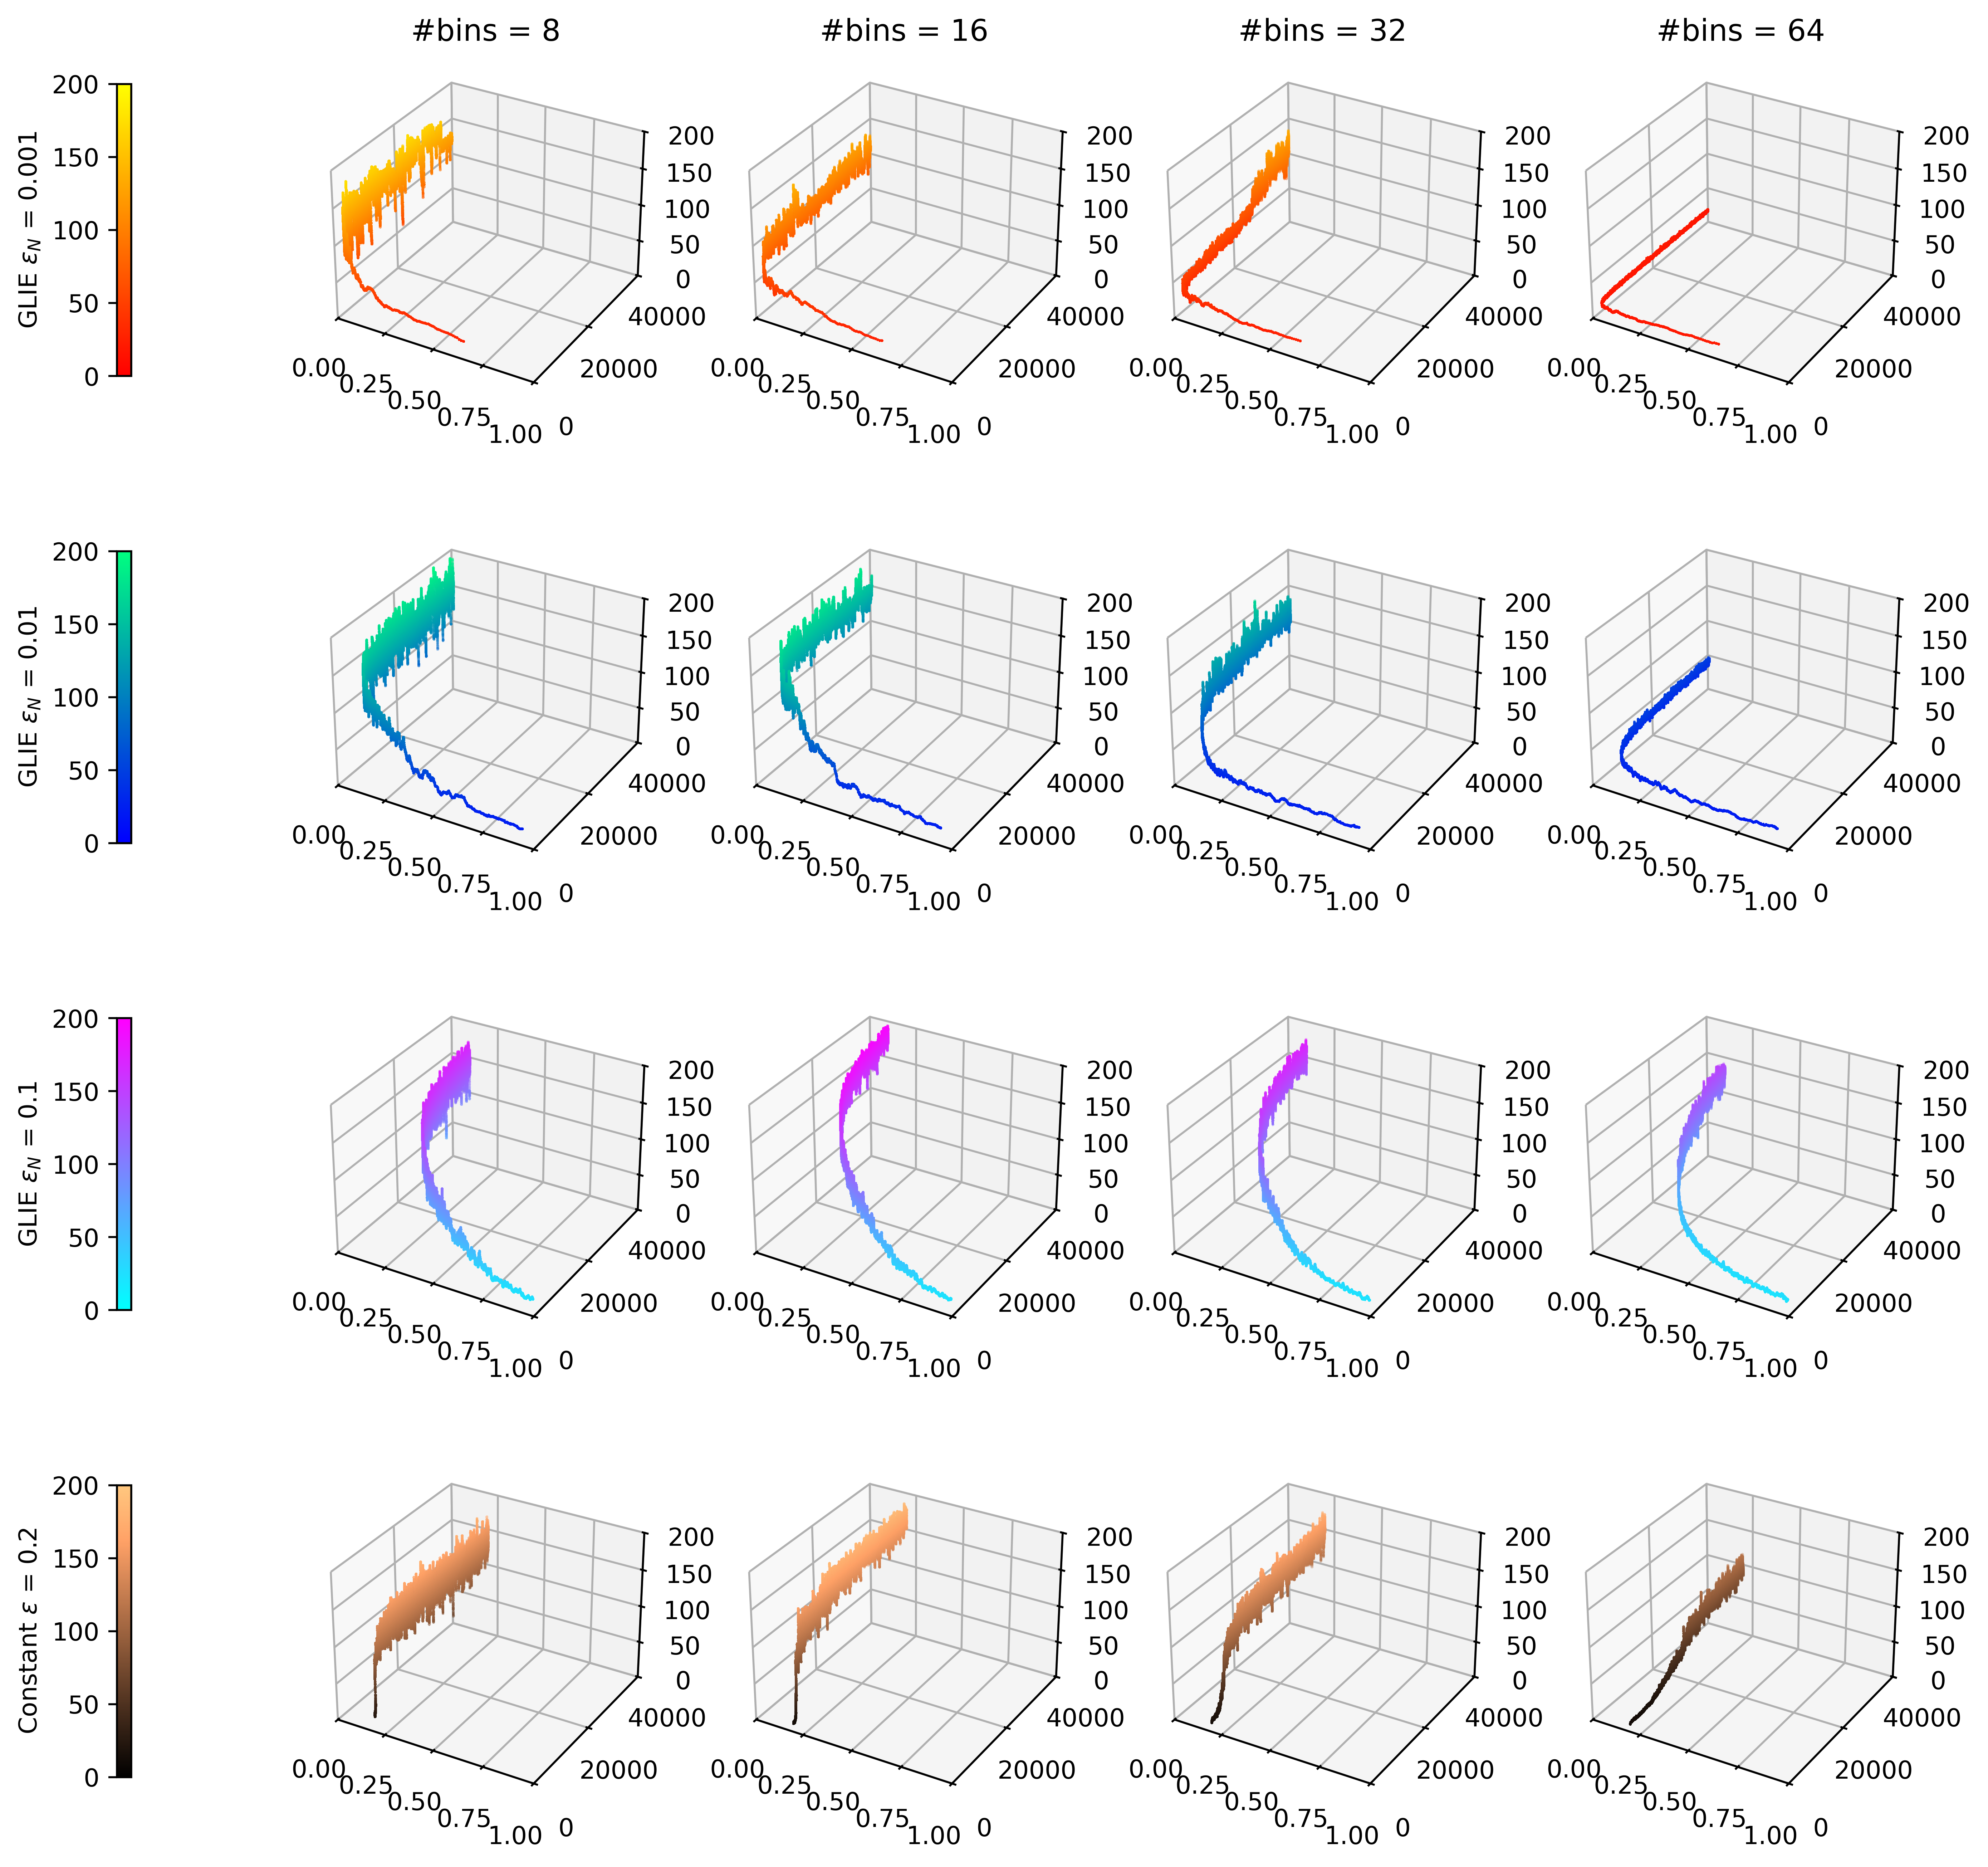

In [45]:
fig, axs = plt.subplots(4, 4, subplot_kw=dict(projection='3d'), figsize=(13, 13), dpi=500)

glie = [0.001, 0.01, 0.1]
discr = [8, 16, 32, 64]

combinations = list(itertools.product(glie, discr))
patches = []
count = 0
for (comb, ax) in zip(combinations, axs.reshape(-1)):
        if count >= 12:
              break
        else:
            out = plot_3d(comb, ax, 'glie')
            if comb[1] == 8:
                patches.append(out)
            count += 1 

out = plot_3d((0.2, 8), axs[3, 0], 'constant')
plot_3d((0.2, 16), axs[3, 1], 'constant')
plot_3d((0.2, 32), axs[3, 2], 'constant')
plot_3d((0.2, 64), axs[3, 3], 'constant')

patches.append(out)

axs[0, 0].set_title('#bins = 8')
axs[0, 1].set_title('#bins = 16')
axs[0, 2].set_title('#bins = 32')
axs[0, 3].set_title('#bins = 64')

fig.colorbar(patches[0], ax=axs[0, :], fraction=0.01, label='GLIE $\epsilon_N$ = 0.001', location='left', shrink=0.75)
fig.colorbar(patches[1], ax=axs[1, :], fraction=0.01, label='GLIE $\epsilon_N$ = 0.01', location='left', shrink=0.75)
fig.colorbar(patches[2], ax=axs[2, :], fraction=0.01, label='GLIE $\epsilon_N$ = 0.1', location='left', shrink=0.75)
fig.colorbar(patches[3], ax=axs[3, :], fraction=0.01, label='Constant $\epsilon$ = 0.2', location='left', shrink=0.75)

In [150]:
with open('rewards_episode_discr/reward_episode_discr16_constant0.2.pkl', 'rb') as f:
        data1 = pkl.load(f)
        window_size = 500
        moving_avg_rew_1 = [np.mean(data1['reward'][i:i+window_size]) for i in range(len(data1[:40_000]) - window_size + 1)]
        std_rew_1 = [np.std(data1['reward'][i:i+window_size]) for i in range(len(data1[:40_000]) - window_size + 1)]
        moving_avg_eps_1 = [np.mean(data1['epsilon'][i:i+window_size]) for i in range(len(data1[:40_000]) - window_size + 1)]
        moving_avg_ep_1 = [np.mean(data1.index[i:i+window_size]) for i in range(len(data1[:40_000]) - window_size + 1)]
with open('rewards_episode_discr/reward_episode_discr16_glie0.1.pkl', 'rb') as f:
        data2 = pkl.load(f)
        moving_avg_rew_2 = [np.mean(data2['reward'][i:i+window_size]) for i in range(len(data2[:40_000]) - window_size + 1)]
        std_rew_2 = [np.std(data2['reward'][i:i+window_size]) for i in range(len(data2[:40_000]) - window_size + 1)]
        moving_avg_eps_2 = [np.mean(data2['epsilon'][i:i+window_size]) for i in range(len(data2[:40_000]) - window_size + 1)]
        moving_avg_ep_2 = [np.mean(data2.index[i:i+window_size]) for i in range(len(data2[:40_000]) - window_size + 1)]
with open('rewards_episode_discr/reward_episode_discr16_glie0.01.pkl', 'rb') as f:
        data3 = pkl.load(f)
        moving_avg_rew_3 = [np.mean(data3['reward'][i:i+window_size]) for i in range(len(data3[:40_000]) - window_size + 1)]
        std_rew_3 = [np.std(data3['reward'][i:i+window_size]) for i in range(len(data3[:40_000]) - window_size + 1)]
        moving_avg_eps_3 = [np.mean(data3['epsilon'][i:i+window_size]) for i in range(len(data3[:40_000]) - window_size + 1)]
        moving_avg_ep_3 = [np.mean(data3.index[i:i+window_size]) for i in range(len(data3[:40_000]) - window_size + 1)]
with open('rewards_episode_discr/reward_episode_discr16_glie0.001.pkl', 'rb') as f:
        data4 = pkl.load(f)
        moving_avg_rew_4 = [np.mean(data4['reward'][i:i+window_size]) for i in range(len(data4[:40_000]) - window_size + 1)]
        std_rew_4 = [np.std(data4['reward'][i:i+window_size]) for i in range(len(data4[:40_000]) - window_size + 1)]
        moving_avg_eps_4 = [np.mean(data4['epsilon'][i:i+window_size]) for i in range(len(data4[:40_000]) - window_size + 1)]
        moving_avg_ep_4 = [np.mean(data4.index[i:i+window_size]) for i in range(len(data4[:40_000]) - window_size + 1)]

In [151]:
cmap1 = plt.get_cmap('copper')(200)
cmap2 = plt.get_cmap('cool')(200)
cmap3 = plt.get_cmap('winter')(200)
cmap4 = plt.get_cmap('autumn')(200)

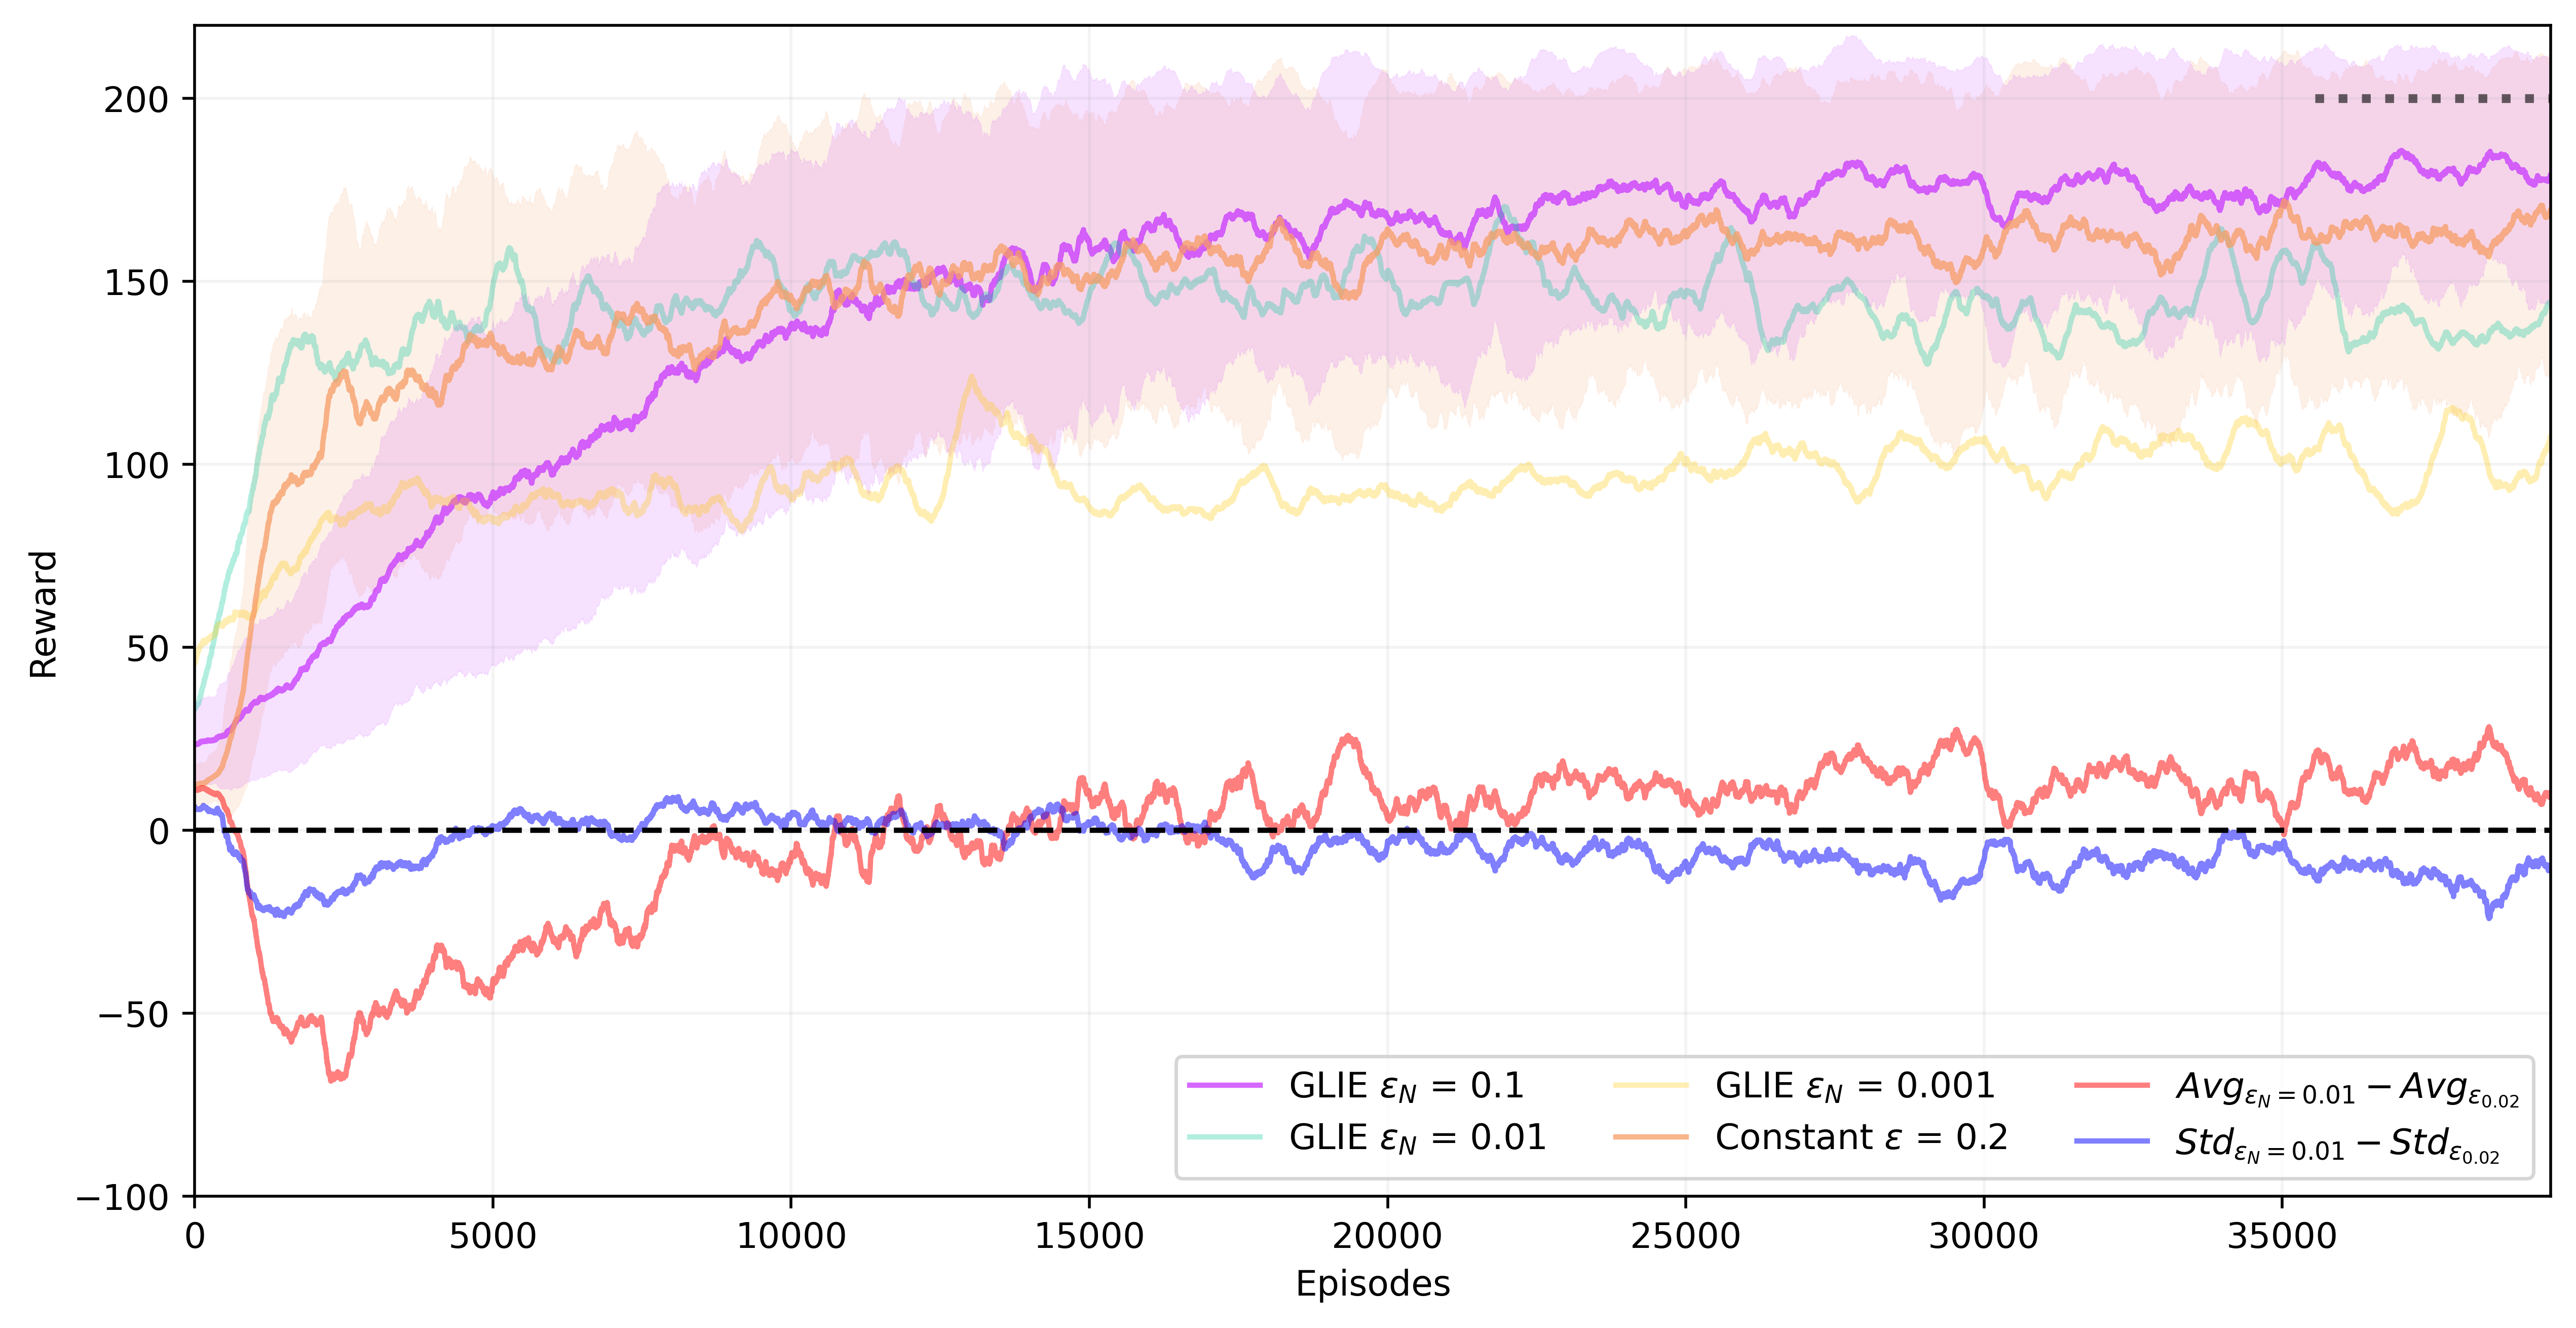

In [154]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=500)
ax.fill_between(range(len(moving_avg_rew_1)), np.array(moving_avg_rew_1) - np.array(std_rew_1), np.array(moving_avg_rew_1) + np.array(std_rew_1), 
                color=cmap1, alpha=0.15, linewidth=0.075)
ax.plot(moving_avg_rew_2, label='GLIE $\epsilon_N$ = 0.1', alpha=0.75, color = cmap2)
ax.fill_between(range(len(moving_avg_rew_2)), np.array(moving_avg_rew_2) - np.array(std_rew_2), np.array(moving_avg_rew_2) + np.array(std_rew_2),
                color=cmap2, alpha=0.15, linewidth=0.075)
ax.plot(moving_avg_rew_3, label='GLIE $\epsilon_N$ = 0.01', alpha=0.3, color = cmap3)
ax.plot(moving_avg_rew_4, label='GLIE $\epsilon_N$ = 0.001', alpha=0.3, color = cmap4)
ax.plot(moving_avg_rew_1, label='Constant $\epsilon$ = 0.2', alpha=0.75, color = cmap1)
ax.plot(np.array(moving_avg_rew_2) - np.array(moving_avg_rew_1), 
        color='red', label='$Avg_{\epsilon_{N}={0.01}} - Avg_{\epsilon_{0.02}}$', alpha = 0.5)
ax.plot(np.array(std_rew_2) - np.array(std_rew_1),
        color='blue', label = '$Std_{\epsilon_{N}={0.01}} - Std_{\epsilon_{0.02}}$', alpha = 0.5)
ax.axhline(0, color='black', linestyle='--')
ax.axhline(200, xmin = 0.9, xmax = 1, color='black', linestyle='dotted', alpha = 0.6, linewidth = 2.5)
ax.set_xlabel('Episodes')
ax.set_xlim(0, len(moving_avg_rew_1))
ax.set_ylim(-100, 220)
ax.set_ylabel('Reward')
ax.legend(ncols=3)
ax.grid(alpha=0.15)

# Constant $\epsilon$ Training

In [ ]:
!python3 qlearning.py --e 0.2 --episodes 40_000 --d 16 --max_timesteps 500

In [ ]:
# Some data has been removed because I was not able to push it to github due to the size limit

In [48]:
data = np.load('values_x_v/q_values_discr8_glie0.1.npy')
im8 = np.mean(np.mean(np.max(data, axis=-1), axis=-1), axis=-1)

data = np.load('values_x_v/q_values_discr16_glie0.1.npy')
im16 = np.mean(np.mean(np.max(data, axis=-1), axis=-1), axis=-1)

data = np.load('values_x_v/q_values_discr32_glie0.1.npy')
im32 = np.mean(np.mean(np.max(data, axis=-1), axis=-1), axis=-1)

data = np.load('values_x_v/q_values_discr64_glie0.1.npy')
im64 = np.mean(np.mean(np.max(data, axis=-1), axis=-1), axis=-1)

[Text(1, 0.0, 'Low Value'), Text(1, 0.6875390665639352, 'High Value')]

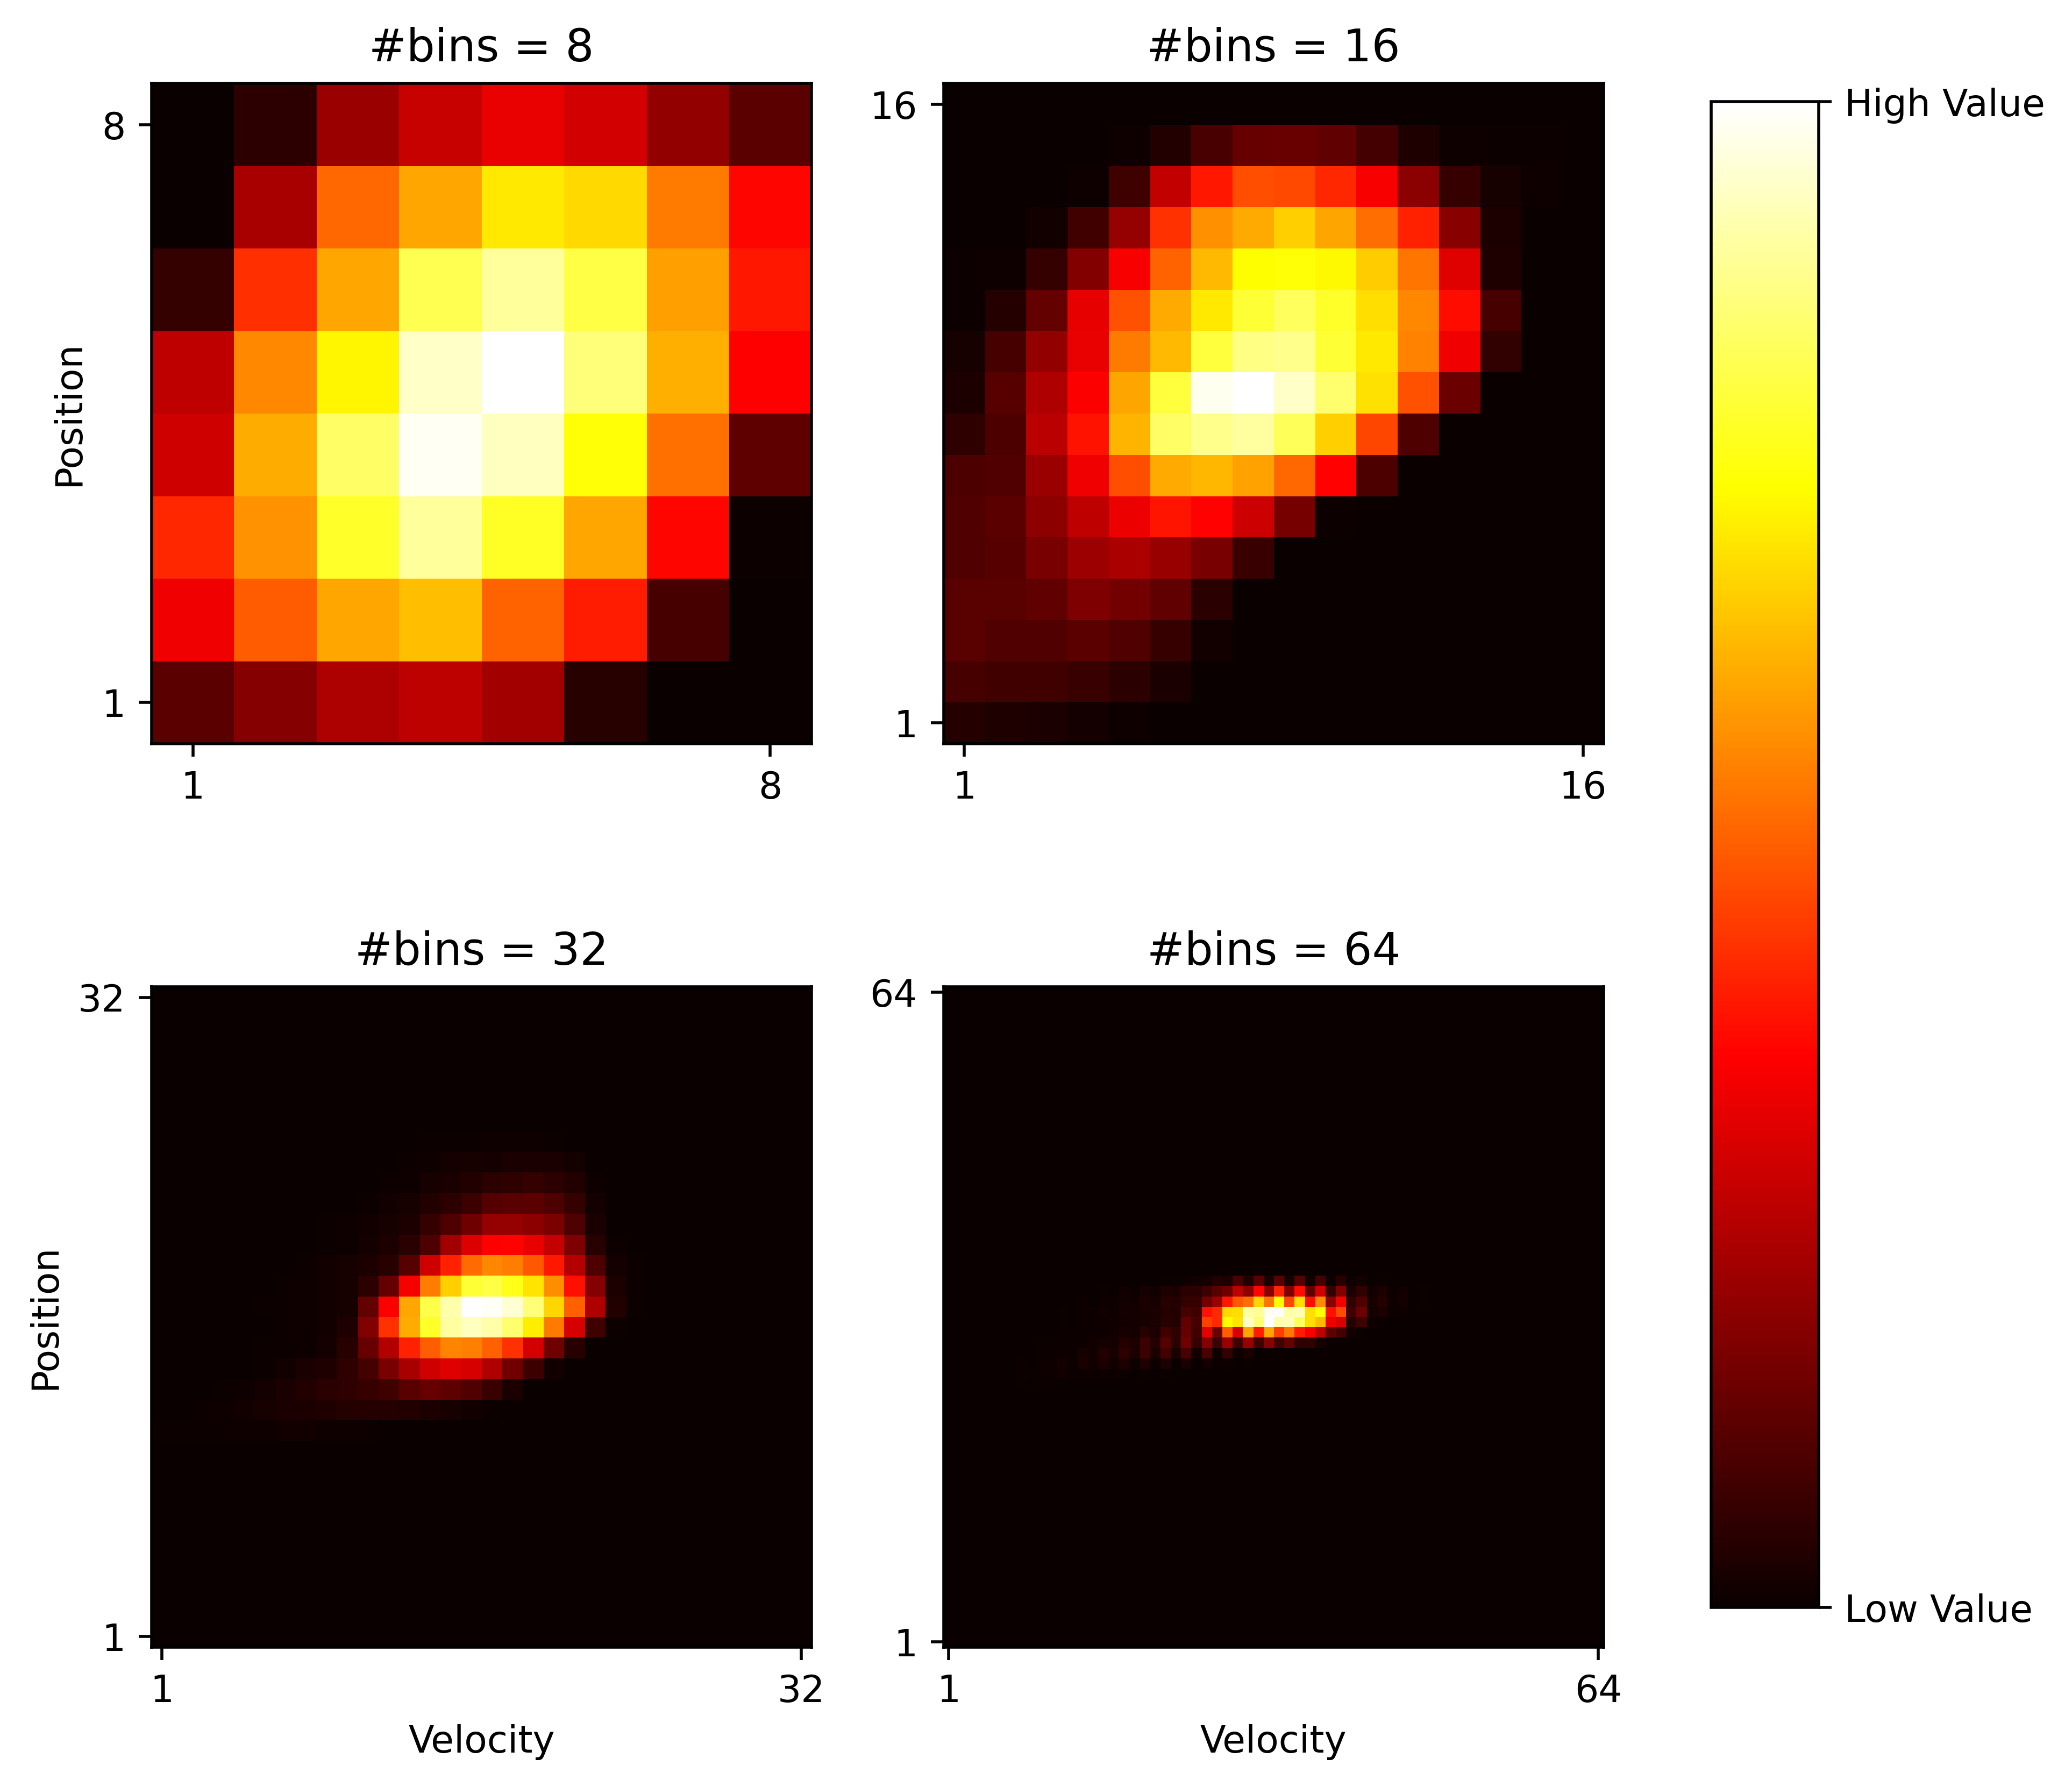

In [76]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=500)
axs[0, 0].imshow(im8, cmap='hot', origin='lower')
axs[0, 0].set_title('#bins = 8')
axs[0, 0].set_xticks([0, 7])
axs[0, 0].set_yticks([0, 7])
axs[0, 0].set_xticklabels([1, 8])
axs[0, 0].set_yticklabels([1, 8])

axs[0, 1].imshow(im16, cmap='hot', origin='lower')
axs[0, 1].set_title('#bins = 16')
axs[0, 1].set_xticks([0, 15])
axs[0, 1].set_yticks([0, 15])
axs[0, 1].set_xticklabels([1, 16])
axs[0, 1].set_yticklabels([1, 16])

axs[1, 0].imshow(im32, cmap='hot', origin='lower')
axs[1, 0].set_title('#bins = 32')
axs[1, 0].set_xticks([0, 31])
axs[1, 0].set_yticks([0, 31])
axs[1, 0].set_xticklabels([1, 32])
axs[1, 0].set_yticklabels([1, 32])

im = axs[1, 1].imshow(im64, cmap='hot', origin='lower')
axs[1, 1].set_title('#bins = 64')
axs[1, 1].set_xticks([0, 63])
axs[1, 1].set_yticks([0, 63])
axs[1, 1].set_xticklabels([1, 64])
axs[1, 1].set_yticklabels([1, 64])
axs[0, 0].set_ylabel('Position')
axs[1, 0].set_ylabel('Position')
axs[1, 0].set_xlabel('Velocity')
axs[1, 1].set_xlabel('Velocity')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, ticks=[np.min(im64), np.max(im64)])

cb.ax.set_yticklabels(['Low Value', 'High Value'])

# Greedy Training

In [ ]:
!python3 qlearning.py --e 0 --episodes 40_000 --d 8 --q_init 10

0.0
10.0
20.0
30.0
40.0
50.0
0.0
10.0
20.0
30.0
40.0
50.0
0.0
10.0
20.0
30.0
40.0
50.0
0.0
10.0
20.0
30.0
40.0
50.0


Text(0.5, 0.92, '#bins = 64')

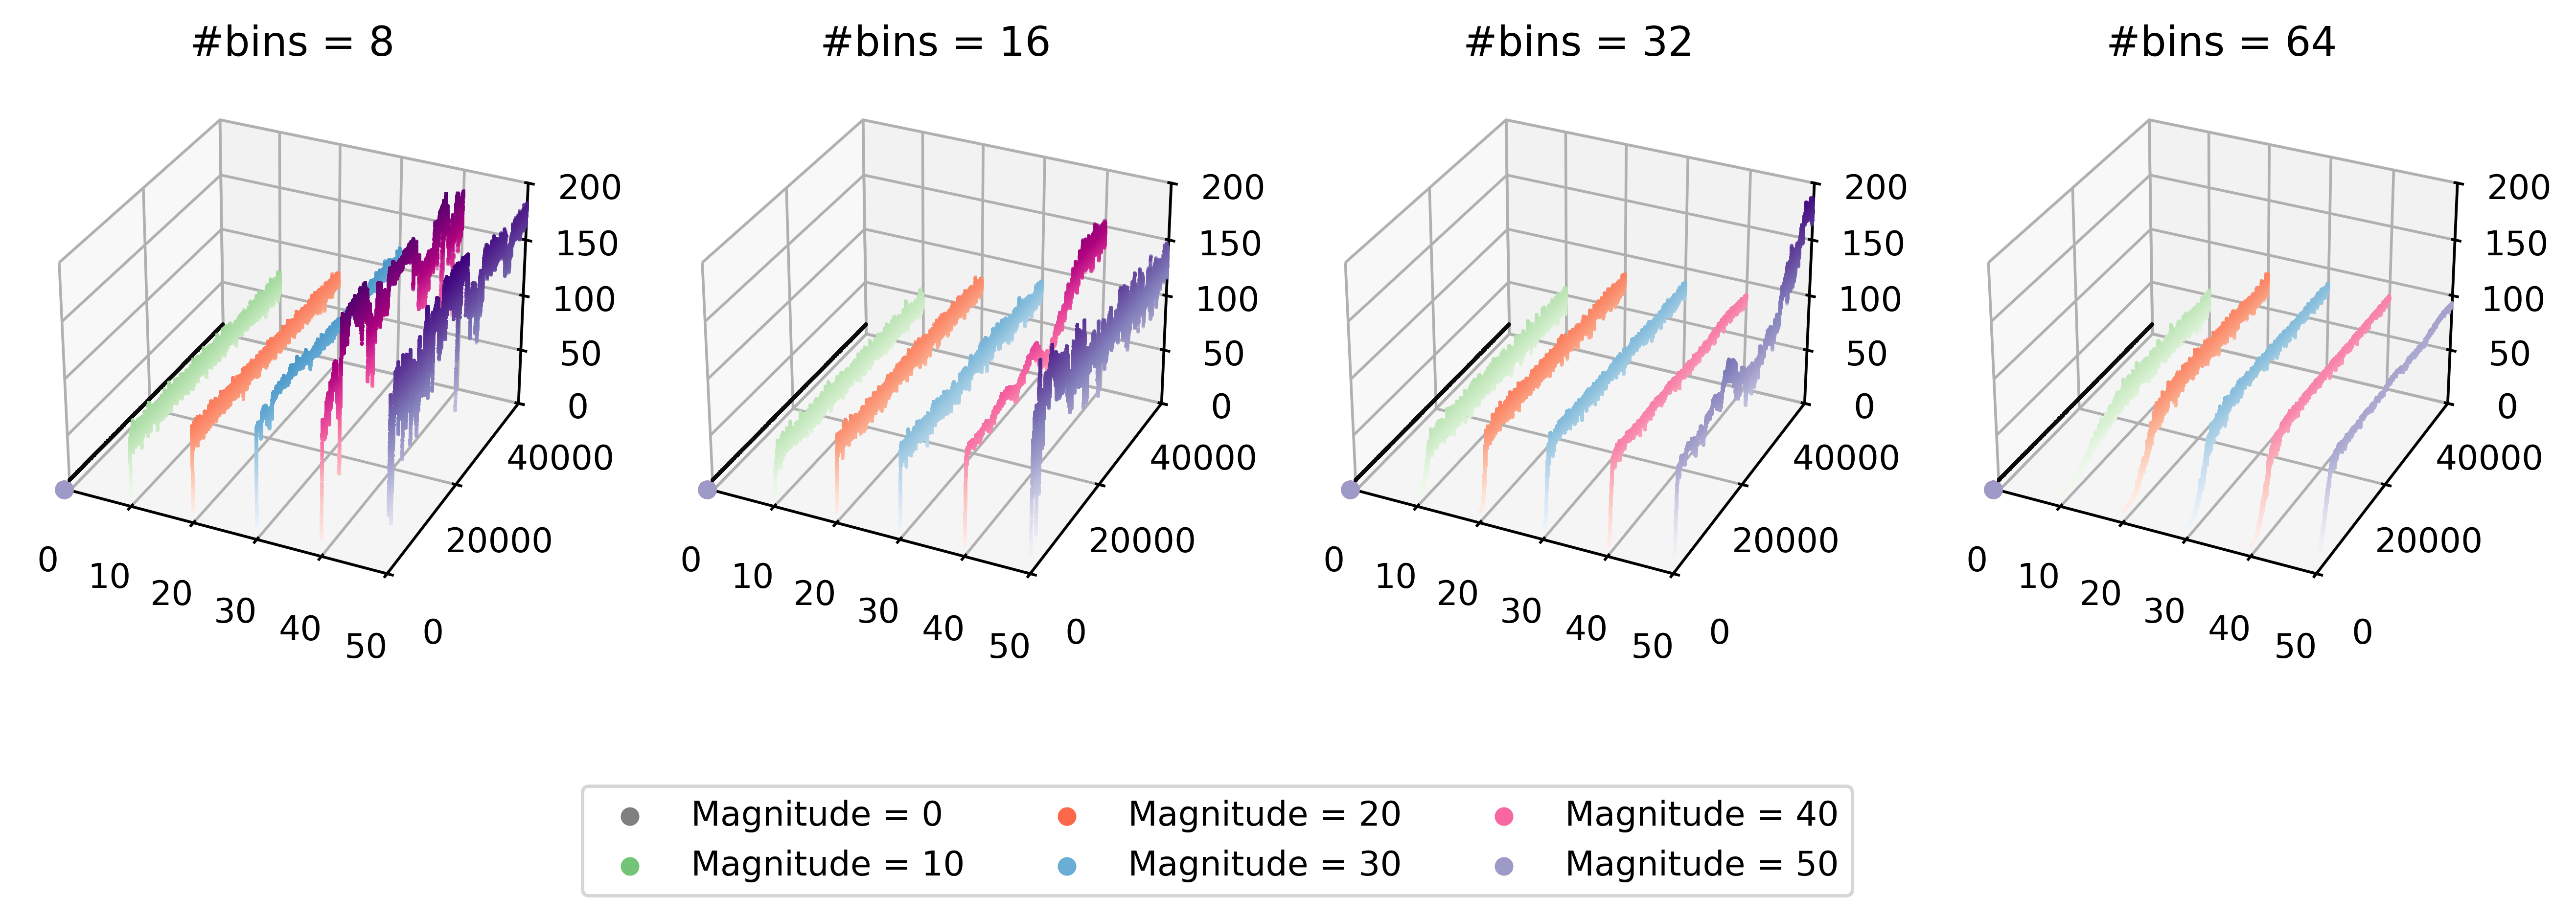

In [78]:
fig, axs = plt.subplots(1, 4, subplot_kw=dict(projection='3d'), figsize=(13, 13), dpi=500)

glie = [0.0]
discr = [8, 16, 32, 64]

combinations = list(itertools.product(glie, discr))
for (comb, ax) in zip(combinations, axs.reshape(-1)):
        out = plot_3d(comb, ax, 'constant', q_init='0.0q')
        out = plot_3d(comb, ax, 'constant', q_init='10.0q')
        out = plot_3d(comb, ax, 'constant', q_init='20.0q')
        out = plot_3d(comb, ax, 'constant', q_init='30.0q')
        out = plot_3d(comb, ax, 'constant', q_init='40.0q')
        out = plot_3d(comb, ax, 'constant', q_init='50.0q')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncols = 3, bbox_to_anchor=(0.5, 0.3), borderaxespad=2, loc='lower center')

axs[0].set_title('#bins = 8')
axs[1].set_title('#bins = 16')
axs[2].set_title('#bins = 32')
axs[3].set_title('#bins = 64')

# DQN

In [ ]:
!python3 dqlearning.py --e 0.1 --episodes 250 --bs 64 --epc 5 --r 50 --max_timesteps 500 --counter_sampling 1 --big_replay 100_000

In [ ]:
with open('DQN_data/dqn1.pkl', 'rb') as f:
    data_1 = pkl.load(f)
    moving_avg_rew_1 = [np.mean(data_1['reward'][i:i+20]) for i in range(len(data_1[:250]) - 20 + 1)]
    moving_avg_ep_1 = [np.mean(data_1['ep_lengths'][i:i+20]) for i in range(len(data_1[:250]) - 20 + 1)]
    moving_var_rew_1 = [np.std(data_1['reward'][i:i+20]) for i in range(len(data_1[:250]) - 20 + 1)]
    moving_var_ep_1 = [np.std(data_1['ep_lengths'][i:i+20]) for i in range(len(data_1[:250]) - 20 + 1)]

with open('DQN_data/dqn2.pkl', 'rb') as f:
    data_2 = pkl.load(f)
    moving_avg_rew_2 = [np.mean(data_2['reward'][i:i+20]) for i in range(len(data_2[:250]) - 20 + 1)]
    moving_avg_ep_2 = [np.mean(data_2['ep_lengths'][i:i+20]) for i in range(len(data_2[:250]) - 20 + 1)]
    moving_var_rew_2 = [np.std(data_2['reward'][i:i+20]) for i in range(len(data_2[:250]) - 20 + 1)]
    moving_var_ep_2 = [np.std(data_2['ep_lengths'][i:i+20]) for i in range(len(data_2[:250]) - 20 + 1)]

with open('DQN_data/dqn3.pkl', 'rb') as f:
    data_3 = pkl.load(f)
    moving_avg_rew_3 = [np.mean(data_3['reward'][i:i+20]) for i in range(len(data_3[:250]) - 20 + 1)]
    moving_avg_ep_3 = [np.mean(data_3['ep_lengths'][i:i+20]) for i in range(len(data_3[:250]) - 20 + 1)]
    moving_var_rew_3 = [np.std(data_3['reward'][i:i+20]) for i in range(len(data_3[:250]) - 20 + 1)]
    moving_var_ep_3 = [np.std(data_3['ep_lengths'][i:i+20]) for i in range(len(data_3[:250]) - 20 + 1)]

with open('DQN_data/dqn4.pkl', 'rb') as f:
    data_4 = pkl.load(f)
    moving_avg_rew_4 = [np.mean(data_4['reward'][i:i+20]) for i in range(len(data_4[:250]) - 20 + 1)]
    moving_avg_ep_4 = [np.mean(data_4['ep_lengths'][i:i+20]) for i in range(len(data_4[:250]) - 20 + 1)]
    moving_var_rew_4 = [np.std(data_4['reward'][i:i+20]) for i in range(len(data_4[:250]) - 20 + 1)]
    moving_var_ep_4 = [np.std(data_4['ep_lengths'][i:i+20]) for i in range(len(data_4[:250]) - 20 + 1)]


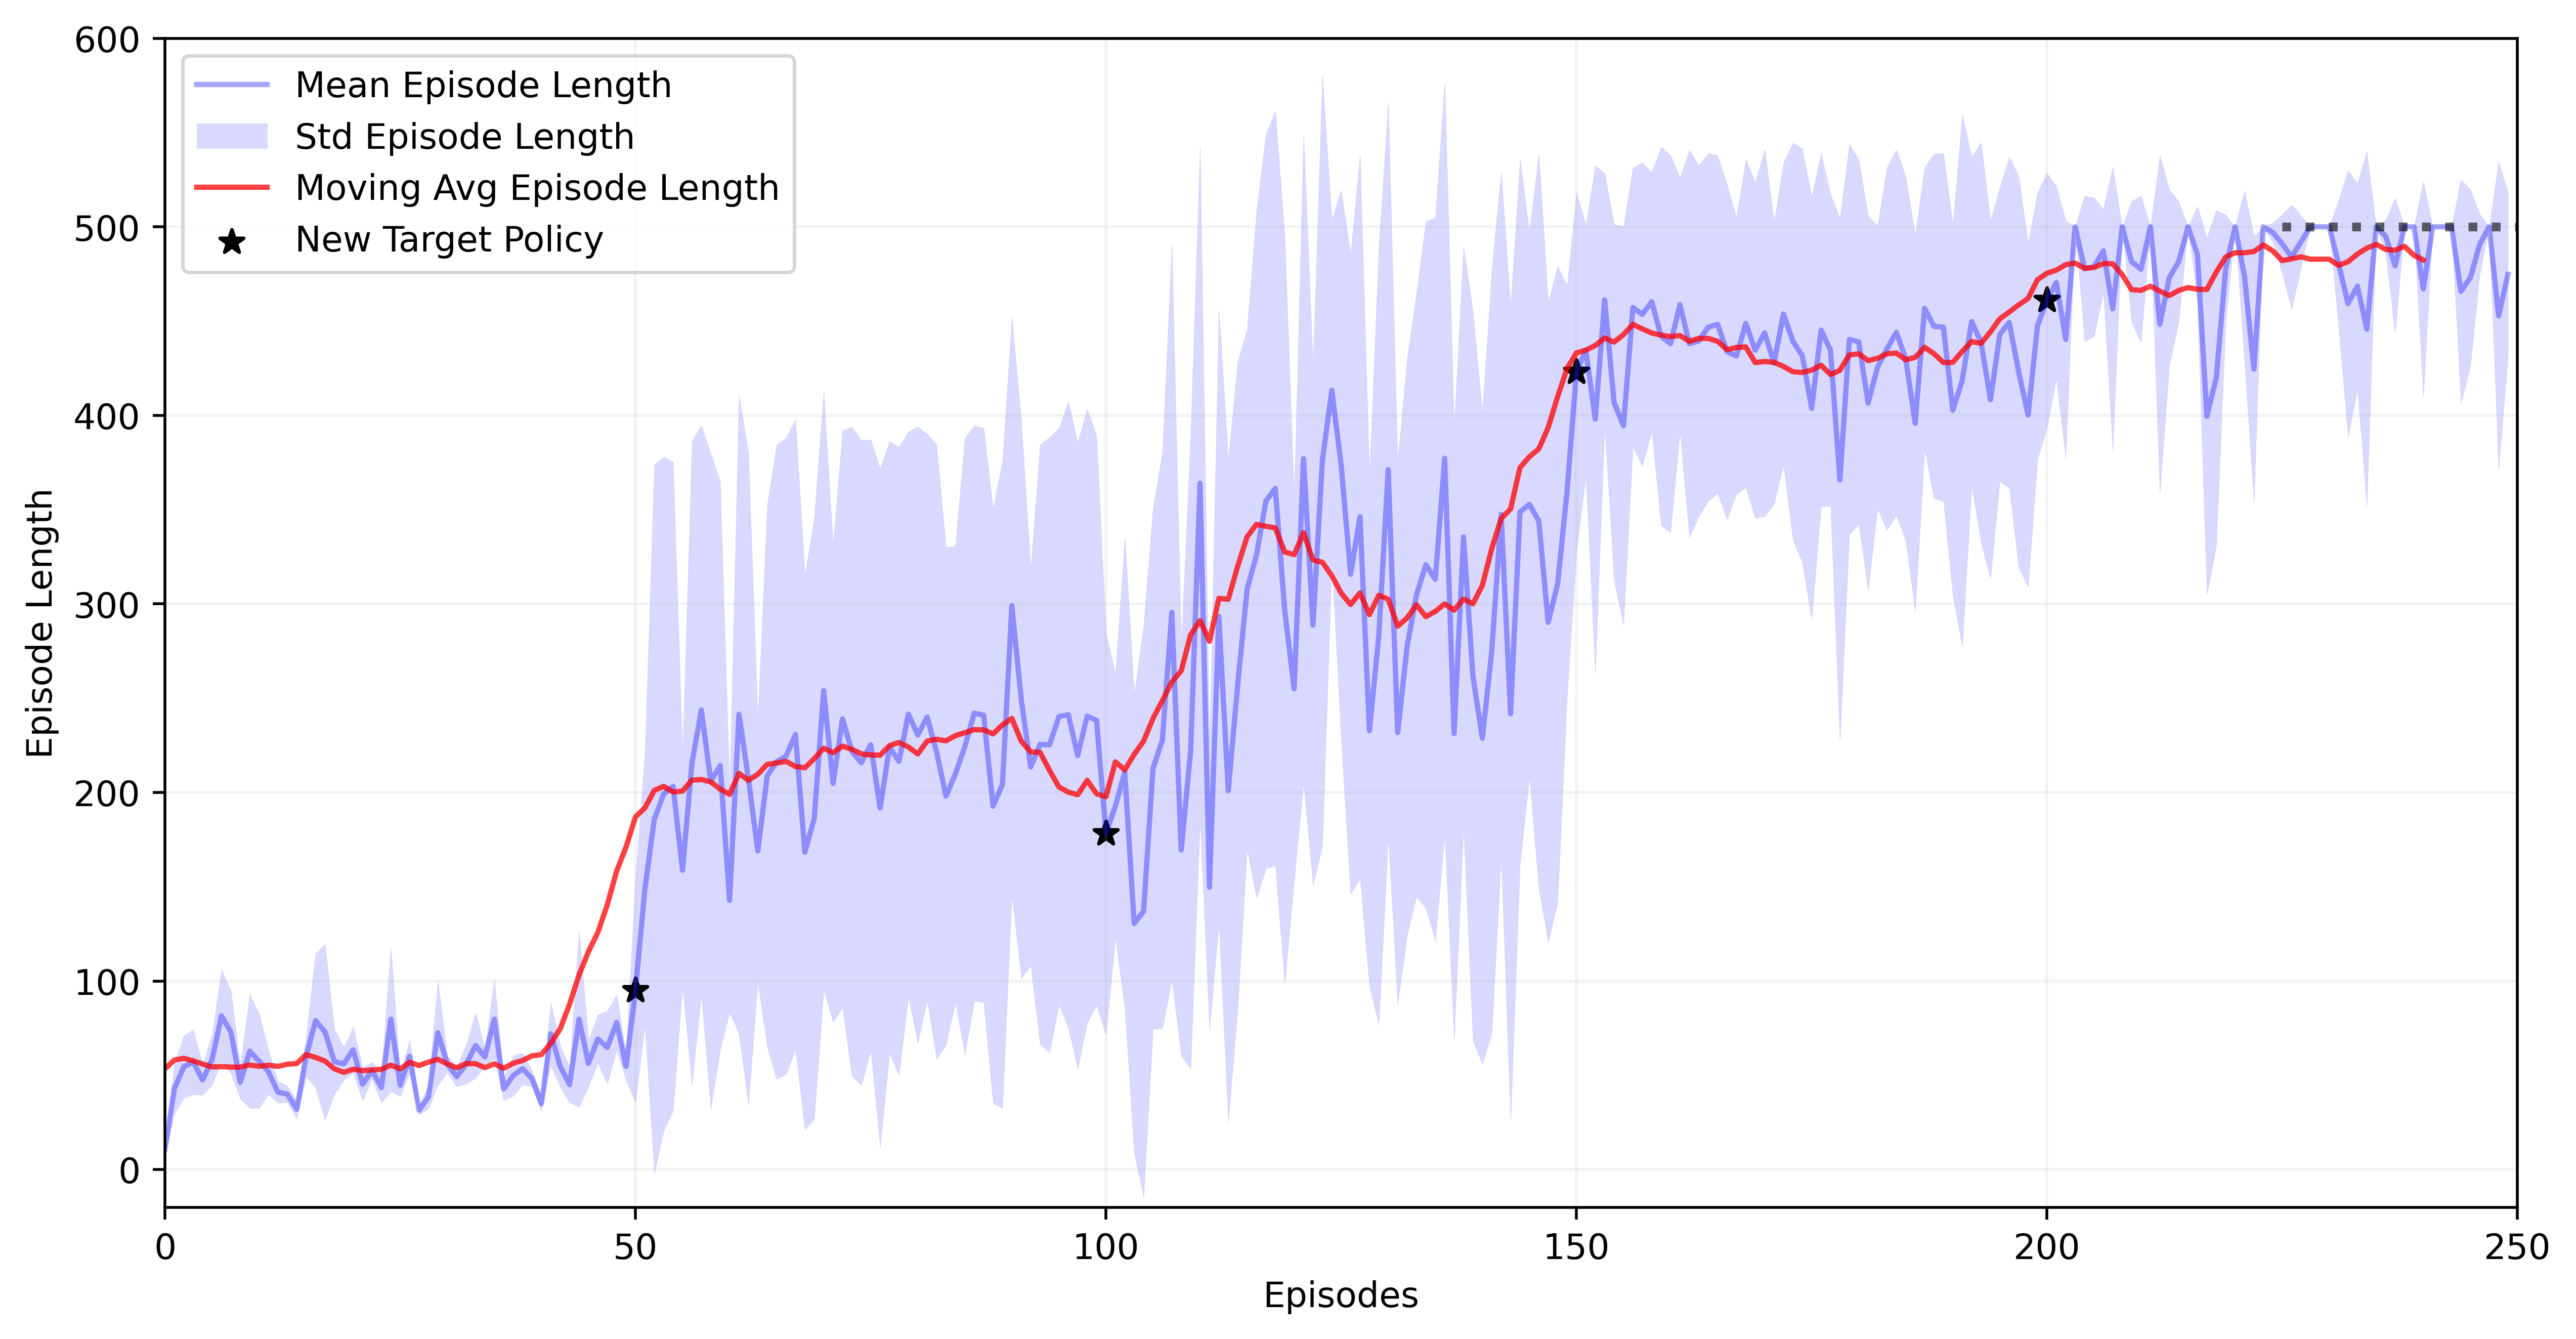

In [148]:
ep_lengths_1 = np.array(data_1['ep_lengths']).reshape(-1, 1)
ep_lengths_2 = np.array(data_2['ep_lengths']).reshape(-1, 1)
ep_lengths_3 = np.array(data_3['ep_lengths']).reshape(-1, 1)
ep_lengths_4 = np.array(data_4['ep_lengths']).reshape(-1, 1)
all_lengths = np.hstack([ep_lengths_1, ep_lengths_2, ep_lengths_3, ep_lengths_4])

changes = [50, 100, 150, 200]

mean_lengths = np.mean(all_lengths, axis=1)
std_lengths = np.std(all_lengths, axis=1)
mean_changes = [np.mean(mean_lengths[change]) for change in changes]

moving_avg_lengths = [np.mean(mean_lengths[i:i+10]) for i in range(len(mean_lengths) - 10 + 1)]

fig, ax = plt.subplots(figsize=(12, 6), dpi=500)

ax.plot(mean_lengths, label='Mean Episode Length', alpha=0.35, color = 'blue')
ax.fill_between(range(len(mean_lengths)), mean_lengths - std_lengths, mean_lengths + std_lengths, 
                 alpha=0.15, label='Std Episode Length', linewidth=0.075, color = 'blue')
ax.plot(moving_avg_lengths, label='Moving Avg Episode Length', alpha=0.75, color = 'red')
ax.scatter(changes, mean_changes, color='black', label='New Target Policy', marker='*', s = 50)
ax.axhline(500, xmin = 0.9, xmax = 1, color='black', linestyle='dotted', alpha = 0.6, linewidth = 2.5)
ax.set_xlabel('Episodes')
ax.set_xlim(0, len(mean_lengths))
ax.set_ylim(-20, 600)
ax.set_ylabel('Episode Length')
ax.legend()
ax.grid(alpha=0.15)
